## 🌐 Connect Colab to Google Drive

In [3]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/MyDrive/PROVE

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive/MyDrive/PROVE


## ⚙️ Import Libraries

In [5]:
# Set seed for reproducibility
seed = 42

# Import necessary libraries
import os

# Set environment variables before importing modules
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd() + '/configs/'

# Suppress warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

# Import necessary modules
import logging
import random
import numpy as np

# Set seeds for random number generators in NumPy and Python
np.random.seed(seed)
random.seed(seed)

# Import TensorFlow and Keras
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl

# Set seed for TensorFlow
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

# Reduce TensorFlow verbosity
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

# Print TensorFlow version
print(tf.__version__)

# Import other libraries
import requests
from io import BytesIO
import cv2
from PIL import Image
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.utils import compute_class_weight
import seaborn as sns

# Configure plot display settings
sns.set(font_scale=1.4)
sns.set_style('white')
plt.rc('font', size=14)
%matplotlib inline

2.17.1


## ⏳ Load Data

In [6]:
data = np.load('training_set.npz')
X = data['images']
y = data['labels']

In [7]:
classes = np.array(np.unique(y))
class_names = ['Basophil','Eosinophil','Erythroblast','Immature granulocytes','Lymphocyte','Monocyte','Neutrophil','Platelet']
print(classes)
print(class_names)
print(len(y))

[0 1 2 3 4 5 6 7]
['Basophil', 'Eosinophil', 'Erythroblast', 'Immature granulocytes', 'Lymphocyte', 'Monocyte', 'Neutrophil', 'Platelet']
13759


#Dataset Inspection:

##1. By randomly plotting a certain number of images from the dataset, we noticed that some images were repeated

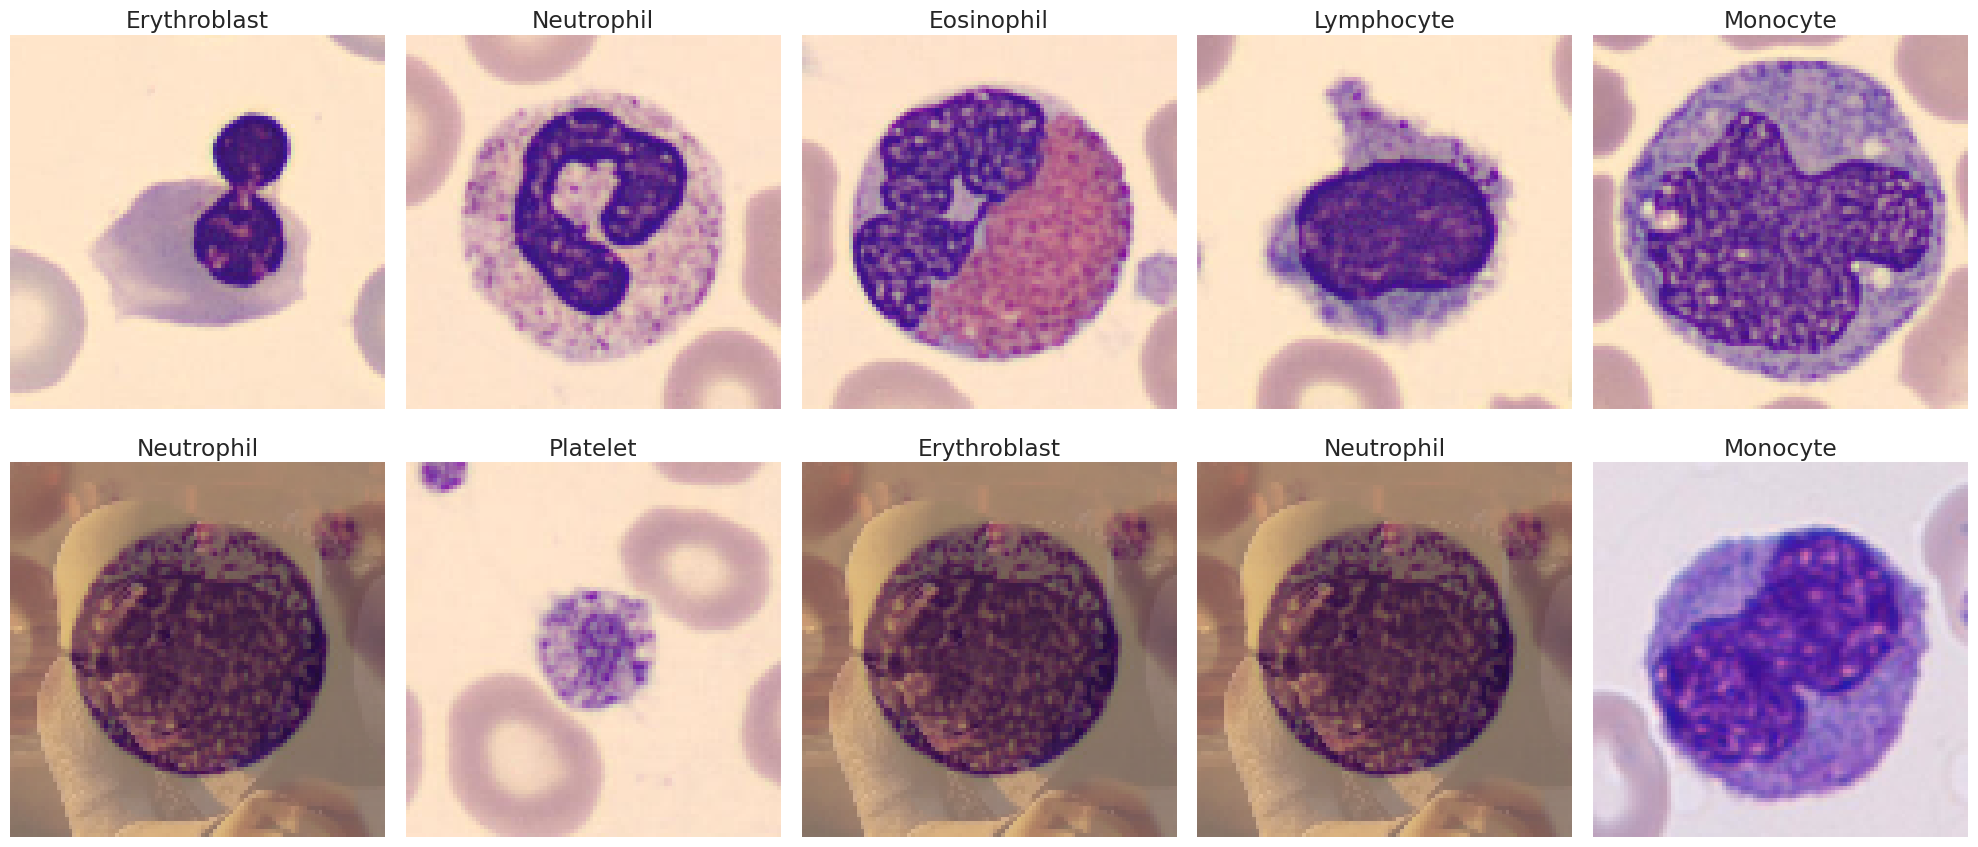

In [12]:
num_img = 10  # Number of images to display
random_indices = random.sample(range(len(X)), num_img)
# Create subplot layout for images
fig, axes = plt.subplots(2, num_img // 2, figsize=(20, 9))

for i, idx in enumerate(random_indices):
    ax = axes[i // 5, i % 5]

    # Display the image at the selected index
    ax.imshow(X[idx])

    # Add class name as title, formatting it to replace underscores with spaces and capitalise
    class_name = class_names[y[idx,0]]
    class_name = class_name.replace('_', ' ').title()
    ax.set_title(class_name, pad=5)

    # Remove axis lines for clearer display
    ax.axis('off')

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

## 2. By plotting the distribution of images per class, we noticed an anomaly in the data starting from image 11959

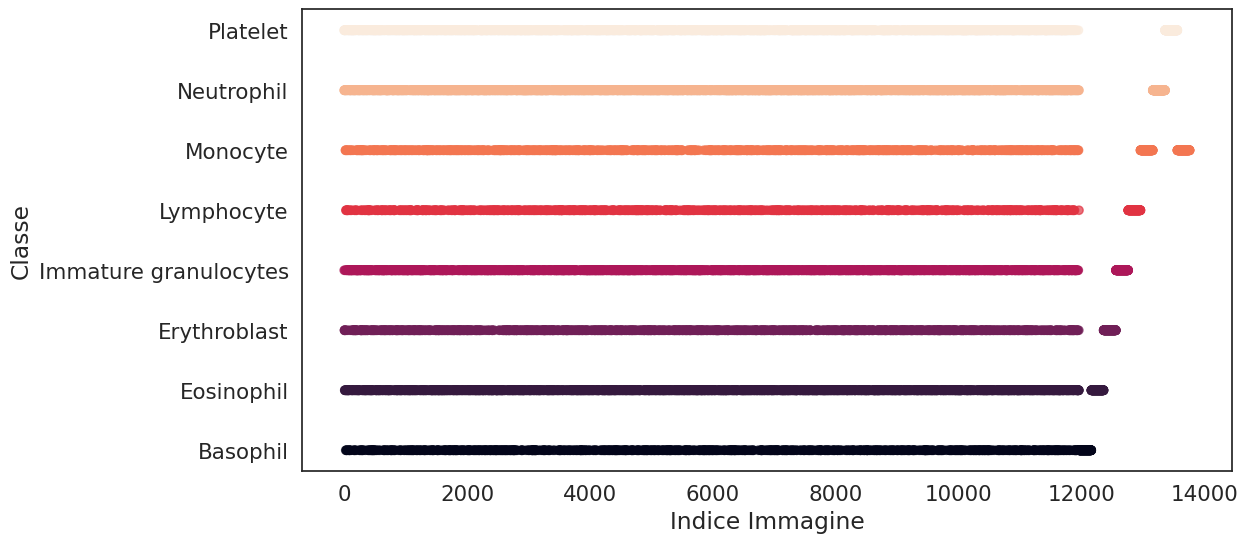

In [9]:
import matplotlib.pyplot as plt

# Creation of image indices
x = np.arange(1,len(y)+1)

# Scatter plot
plt.figure(figsize=(12, 6))
plt.scatter(x, y, c=y, alpha=0.7)
plt.xlabel('Indice Immagine')
plt.ylabel('Classe')
plt.yticks(ticks=classes, labels=class_names)
plt.show()

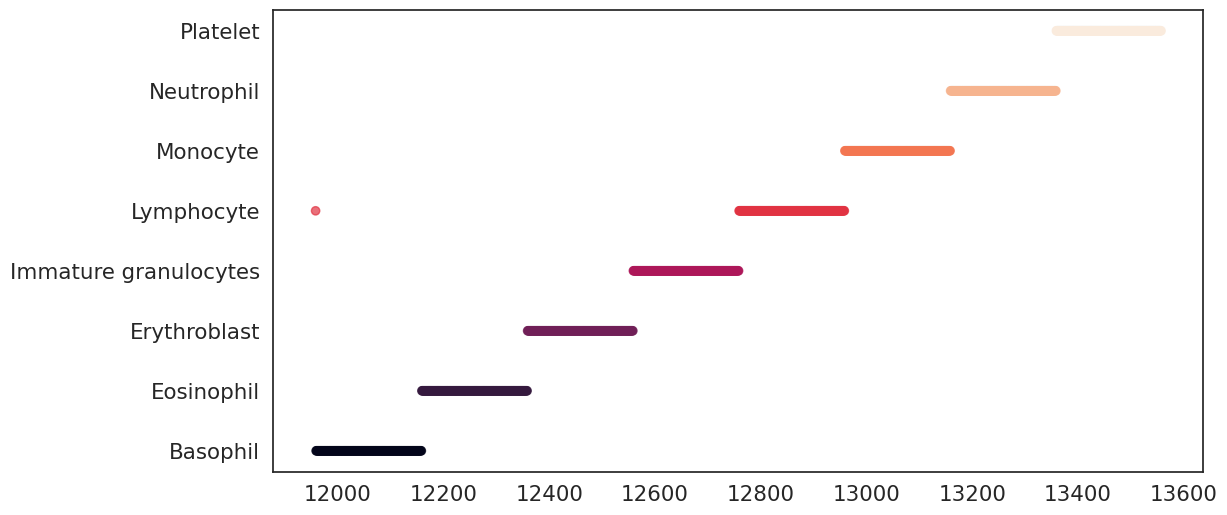

In [13]:
import matplotlib.pyplot as plt

# Creation of image indices
x = np.arange(11958, 13558)

# Scatter plot
plt.figure(figsize=(12, 6))
plt.scatter(x, y[11958:13558], c=y[11958:13558], alpha=0.7)
plt.yticks(ticks=classes, labels=class_names)
plt.show()

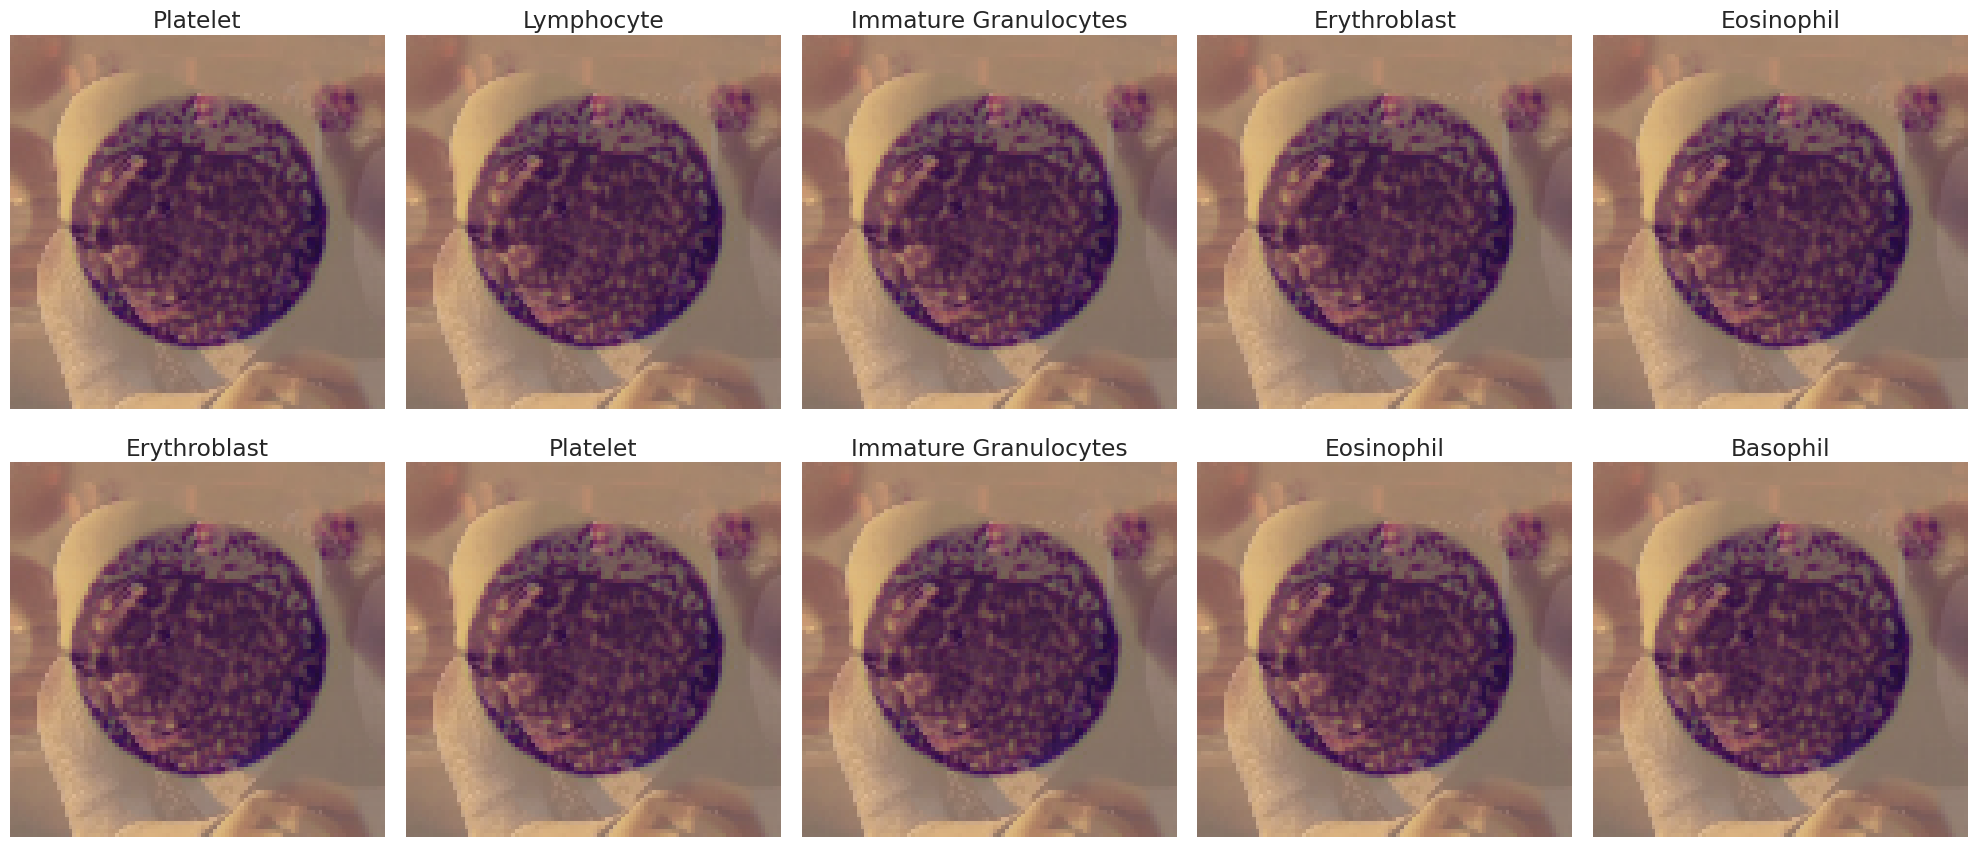

In [14]:
num_img = 10  # Number of images to display
random_indices = random.sample(range(11959, 13559), num_img)
# Create subplot layout for images
fig, axes = plt.subplots(2, num_img // 2, figsize=(20, 9))

for i, idx in enumerate(random_indices):
    ax = axes[i // 5, i % 5]

    # Display the image at the selected index
    ax.imshow(X[idx])

    # Add class name as title, formatting it to replace underscores with spaces and capitalise
    class_name = class_names[y[idx,0]]
    class_name = class_name.replace('_', ' ').title()
    ax.set_title(class_name, pad=5)

    # Remove axis lines for clearer display
    ax.axis('off')

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

##**The same image is repeated and included in all classes => Remove**


## 3. The lack of significant variation in the scatter plot may indicate issues like repeated images or class imbalance

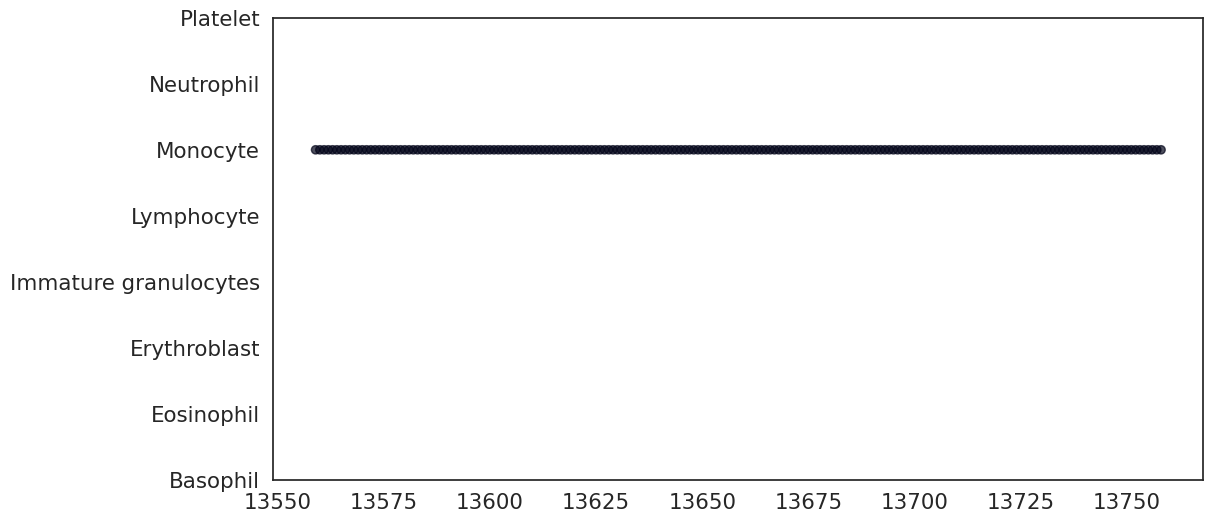

In [15]:
import matplotlib.pyplot as plt

# Creazione degli indici delle immagini
x = np.arange(13559, 13759)  # Indice progressivo delle immagini

# Scatter plot
plt.figure(figsize=(12, 6))
plt.scatter(x, y[13559:13759], c=y[13559:13759], alpha=0.7)
plt.yticks(ticks=classes, labels=class_names)  # Mostra i nomi delle classi sull'asse y
plt.show()


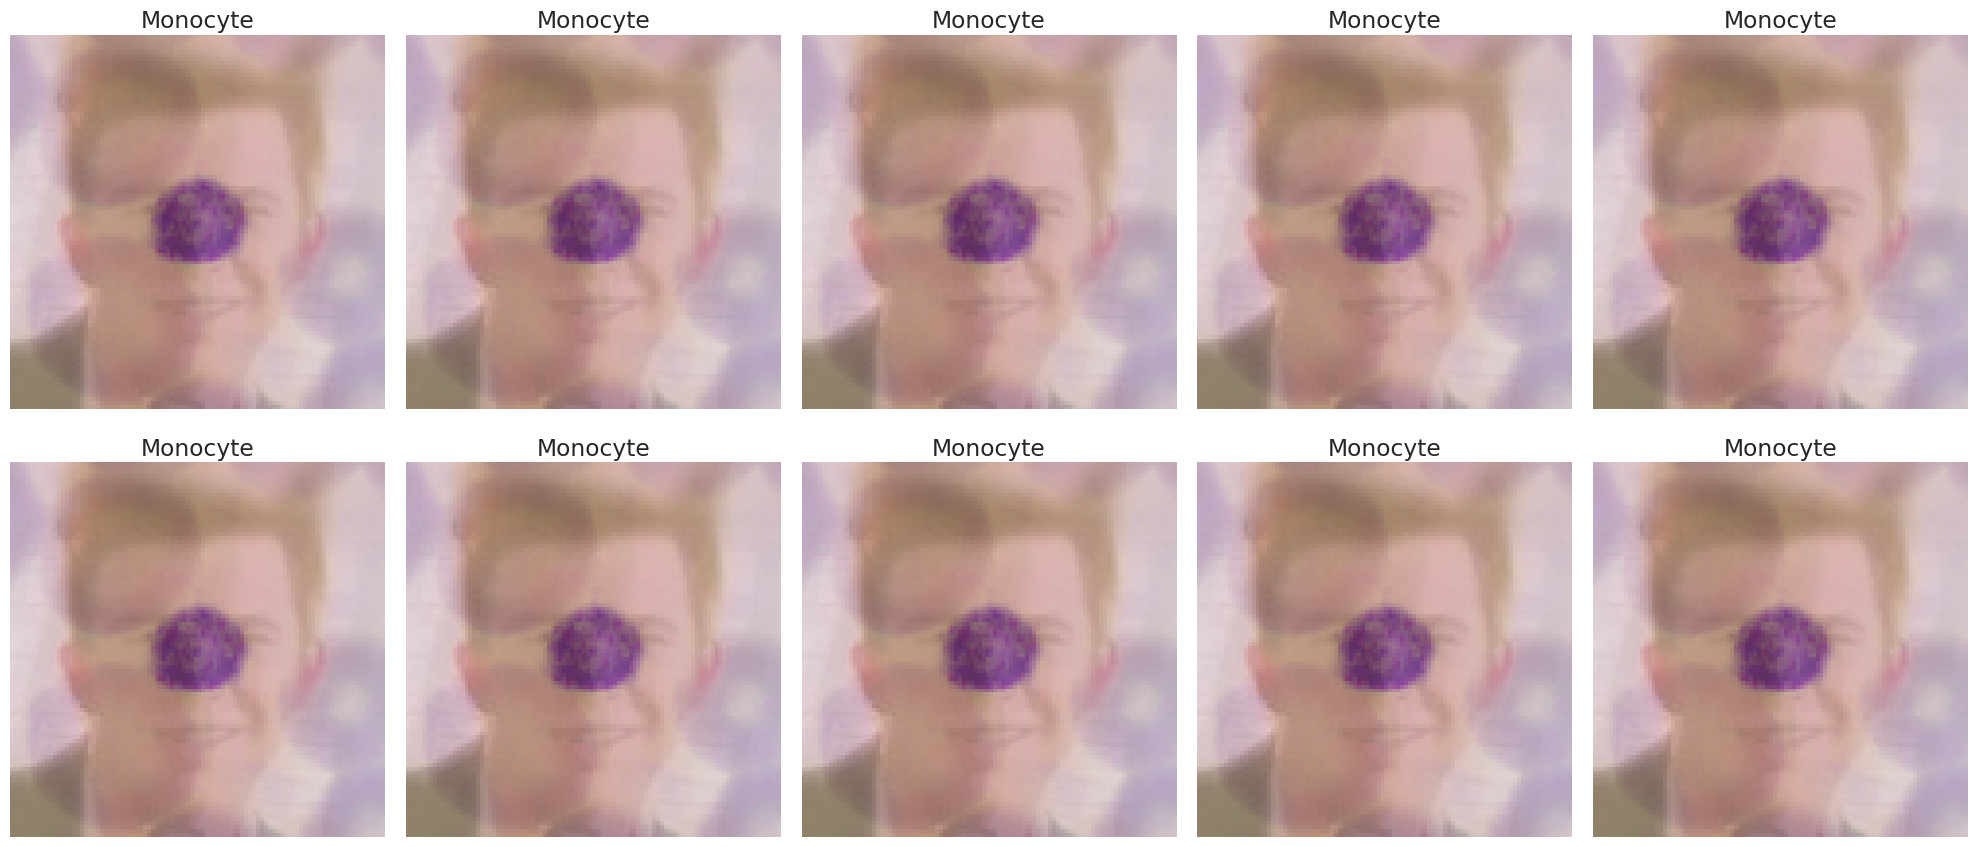

In [16]:
num_img = 10  # Number of images to display
random_indices = random.sample(range(13559, 13759), num_img)
# Create subplot layout for images
fig, axes = plt.subplots(2, num_img // 2, figsize=(20, 9))

for i, idx in enumerate(random_indices):
    ax = axes[i // 5, i % 5]

    # Display the image at the selected index
    ax.imshow(X[idx])

    # Add class name as title, formatting it to replace underscores with spaces and capitalise
    class_name = class_names[y[idx,0]]
    class_name = class_name.replace('_', ' ').title()
    ax.set_title(class_name, pad=5)

    # Remove axis lines for clearer display
    ax.axis('off')

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

##**The same image is repeated multiple times and it is clearly an outlier => Remove**

##4. We will now proceed with the division of the dataset

In [17]:
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=seed, test_size=0.25, stratify=y)

## 5. Next, we analyze the distribution of the training data for each class

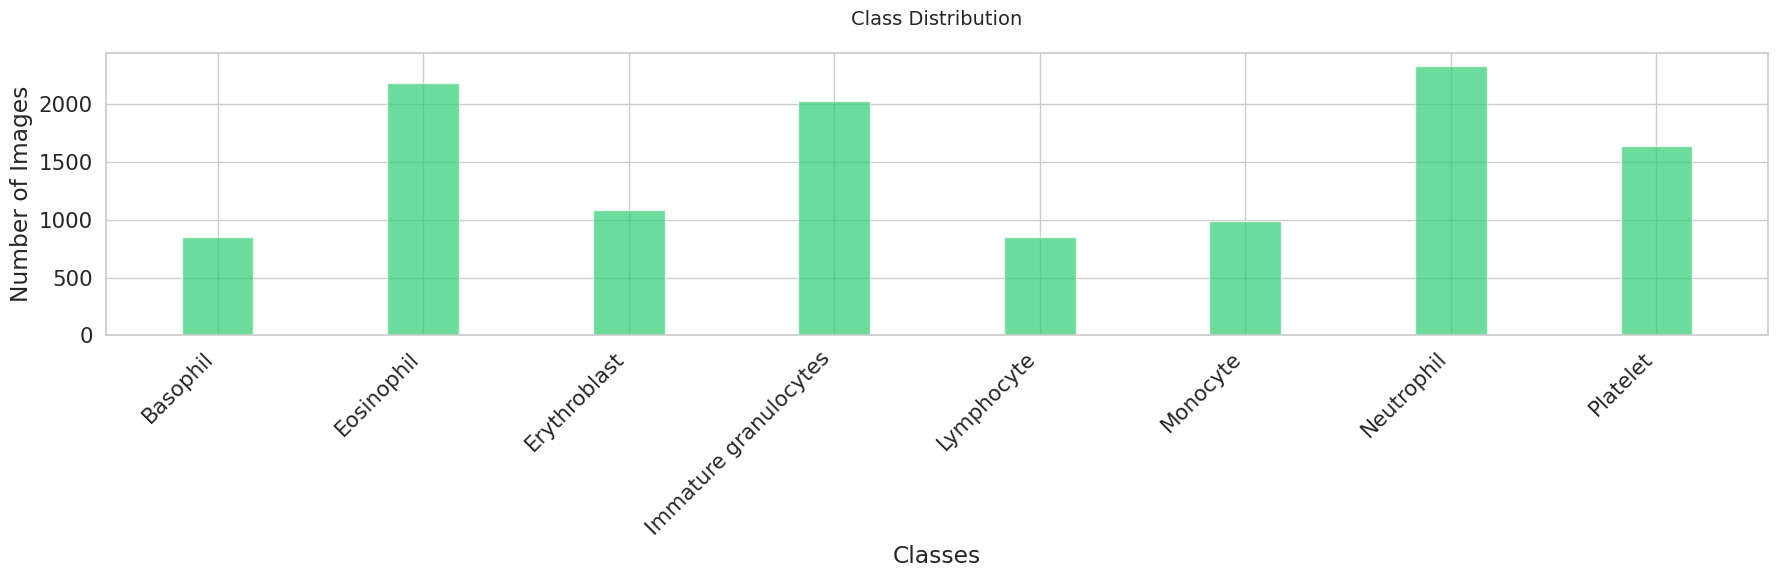

In [18]:
def plot_class_distribution(y, class_names):
    # Set seaborn style for the plot
    sns.set_style("whitegrid")
    plt.figure(figsize=(18, 6))

    # Calculate class distributions for training and test sets
    dist = np.bincount(y.flatten())

    # Create x positions and set bar width
    x = np.arange(len(class_names))
    width = 0.35

    # Plot bars for training and test distributions
    plt.bar(x, dist, width, label='Training', color='#2ecc71', alpha=0.7)

    # Customise plot title and labels
    plt.title('Class Distribution', pad=20, fontsize=14)
    plt.xlabel('Classes')
    plt.ylabel('Number of Images')

    # Set class names as x-axis labels with rotation
    plt.xticks(x, class_names, rotation=45, ha='right')

    # Adjust layout for optimal spacing
    plt.tight_layout()
    plt.show()


y=y[:11958]
# Execute function to plot class distribution
plot_class_distribution(y, class_names)


Due to the evident class imbalance, we attempted to apply techniques to address this issue:

*   Class_weight during training
*   Augmentation
